# Project 1: Facebook dataset (political ads)

**Team members: Ronald (leader) & MD Abdullah (assistant)**<br>

### About dataset
Source: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

*This is a clean dataset of 253,680 survey responses to the CDC's BRFSS2015. The target variable Diabetes_012 has 3 classes. 0 is for no diabetes or only during pregnancy, 1 is for prediabetes, and 2 is for diabetes. There is class imbalance in this dataset. This dataset has 21 feature variables*

The data file of the following columns:

**Diabetes_binary**
0 = no diabetes 1 = diabetes

**HighBP**
0 = no high BP 1 = high BP

**HighChol**
0 = no high cholesterol 1 = high cholesterol

**CholCheck**
0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years

**BMI**
Body Mass Index

**Smoker**
Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes

**Stroke**
(Ever told) you had a stroke. 0 = no 1 = yes

**HeartDiseaseorAttack**
coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes

**PhysActivity**
physical activity in past 30 days - not including job 0 = no 1 = yes

**Fruits**
Consume Fruit 1 or more times per day 0 = no 1 = yes 

**Veggies**
Consume Vegetables 1 or more times per day 0 = no 1 = yes

**HvyAlcoholConsump**
Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no 1 = yes

**AnyHealthcare**
Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes

**NoDocbcCost**
Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes

**GenHlth**
Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor

**MentHlth**
Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good? scale 1-30 days

**PhysHlth**
Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? scale 1-30 days

**DiffWalk**
Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes

**Sex**
0 = female 1 = male

**Age**
13-level age category (AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older

**Education**
Education level (EDUCA see codebook) scale 1-6 1 = Never attended school or only kindergarten 2 = Grades 1 through 8 (Elementary) 3 = Grades 9 through 11 (Some high school) 4 = Grade 12 or GED (High school graduate) 5 = College 1 year to 3 years (Some college or technical school) 6 = College 4 years or more (College graduate)

**Income**
Income scale (INCOME2 see codebook) scale 1-8. 1 = less than 10k USD; 5 = less than 35k USD; 8 = 75k+ USD 

## Some first thoughts
Many different types of analysis can be done on this dataset. 

The most obvious one would be to try predict *diabetes* from the other variables.

Our observations and analyses in this report will mainly be done from that perspective.

In [1]:
# reference to the data
data_file = './data/diabetes_binary_health_indicators_BRFSS2015.csv'

## Imports and settings

In [11]:
# general imports
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
# Store the mean accuracy for each C
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import time
import warnings

# import my personal library
sys.path.insert(0, '../../../ronaldlib/')
import ronaldlib.utils as rutils

# settings
pd.options.display.float_format = "{:.2f}".format
warnings.filterwarnings('ignore', 'The objective has been evaluated ')
warnings.filterwarnings('ignore', 'The max_iter was reached ')
warnings.filterwarnings('ignore', 'The least populated class in ')

## Inspecting the data columns: basic summary

In [3]:
# load the data
df = rutils.load_data(data_file, resave_as_pickle=True)

# show some column info
rutils.show_column_info(df, show_centrality_and_dispersion=False)

loading data from pickle file...
data loaded (took 0.0 seconds)
            COLUMN     TYPE  VALID CNT  MISSING CNT  UNIQUE CNT
0   Diabetes_bi...  float64     253680            0           2
1           HighBP  float64     253680            0           2
2         HighChol  float64     253680            0           2
3        CholCheck  float64     253680            0           2
4           Smoker  float64     253680            0           2
5           Stroke  float64     253680            0           2
6   HeartDiseas...  float64     253680            0           2
7     PhysActivity  float64     253680            0           2
8           Fruits  float64     253680            0           2
9          Veggies  float64     253680            0           2
10  HvyAlcoholC...  float64     253680            0           2
11   AnyHealthcare  float64     253680            0           2
12     NoDocbcCost  float64     253680            0           2
13        DiffWalk  float64     253680  

### Observations
* No missing data (yay!)
* 250k+ rows (yay!)
* Most columns are binary (but we already knew this from the data description)

## Inspecting the data columns: histograms

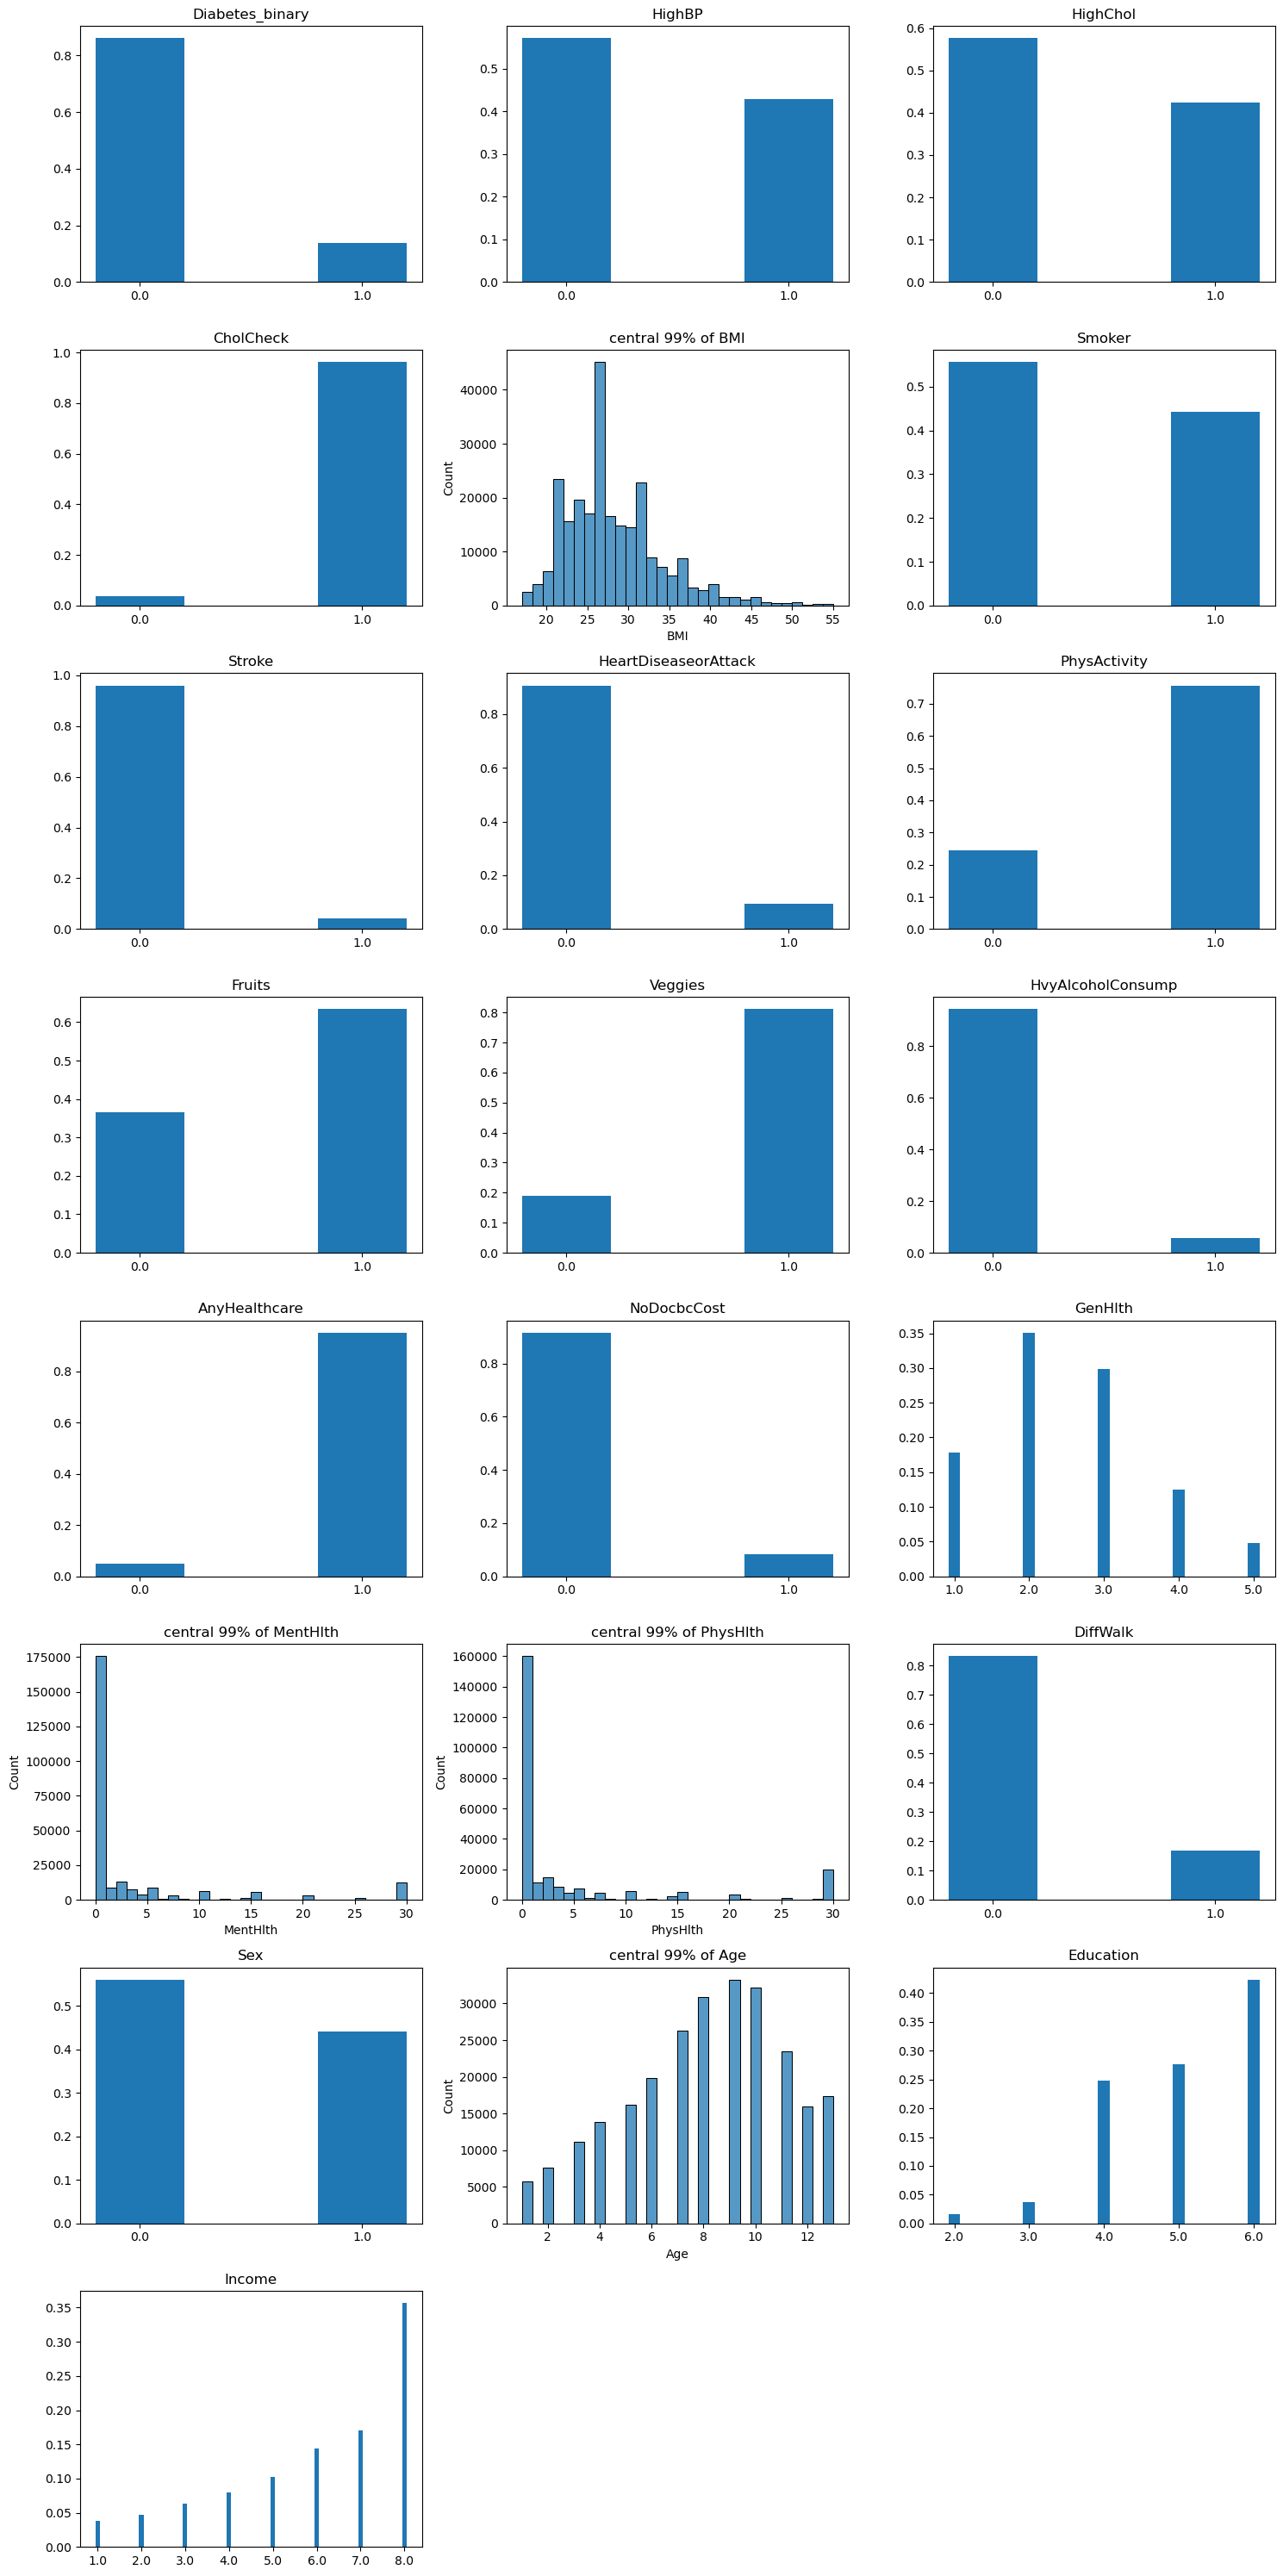

In [4]:
# create a histogram for each numeric column
rutils.create_column_histograms(df, hist_tail_cut=1)

### Observations:
* Imbalanced dataset in the dependent variable: many more diabetes=1 vs diabetes=0
* Some variables have very little variation (like AnyHealthCare, which is 1 for almost everyone) and are thus likely to be uninformative
* Overall this all looks nice, though - no signs of errors or weirdness in the data so far

## Inspecting the data columns: diabetes prevalence for each feature value

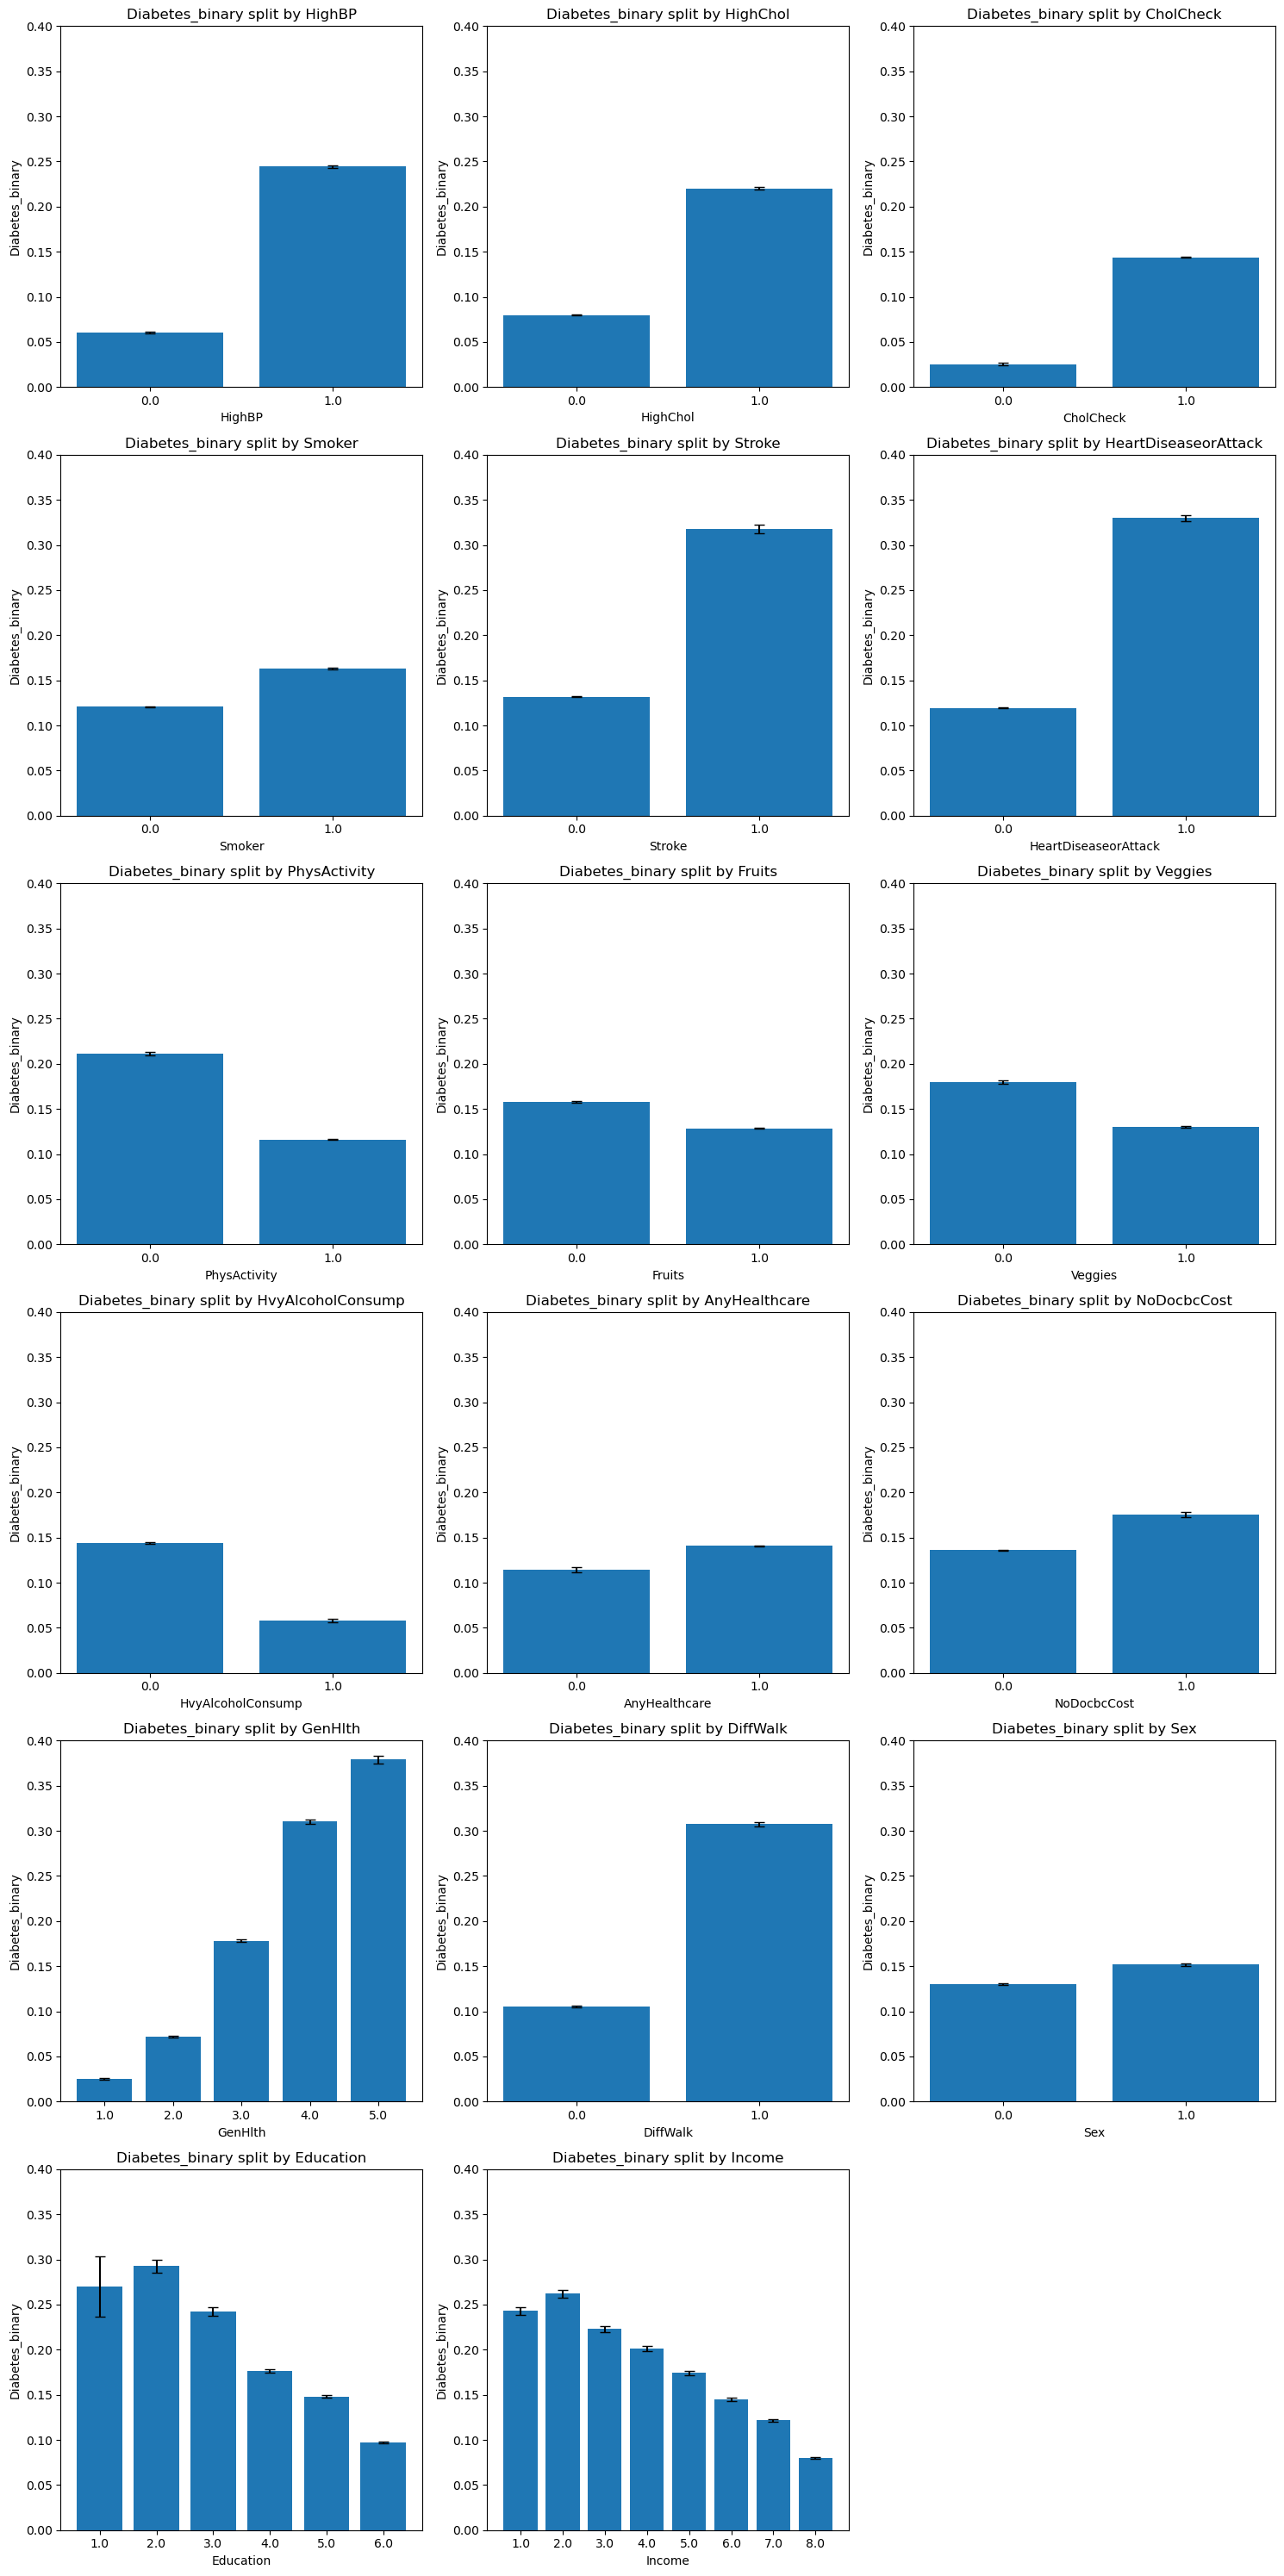

In [5]:
# for all categorical features (defined as features with <= 10 unique values), plot the mean of the dependent variable as a function of the feature value
rutils.plot_target_var_split_by_feature_level(df, target_col='Diabetes_binary', max_levels=10, ylims=(0, 0.4))

### Observations
* For most features, prevalence of diabetes is higher for some feature values than for others
* Hence, most features have some predictive value

## Inspecting the data columns: boxplots

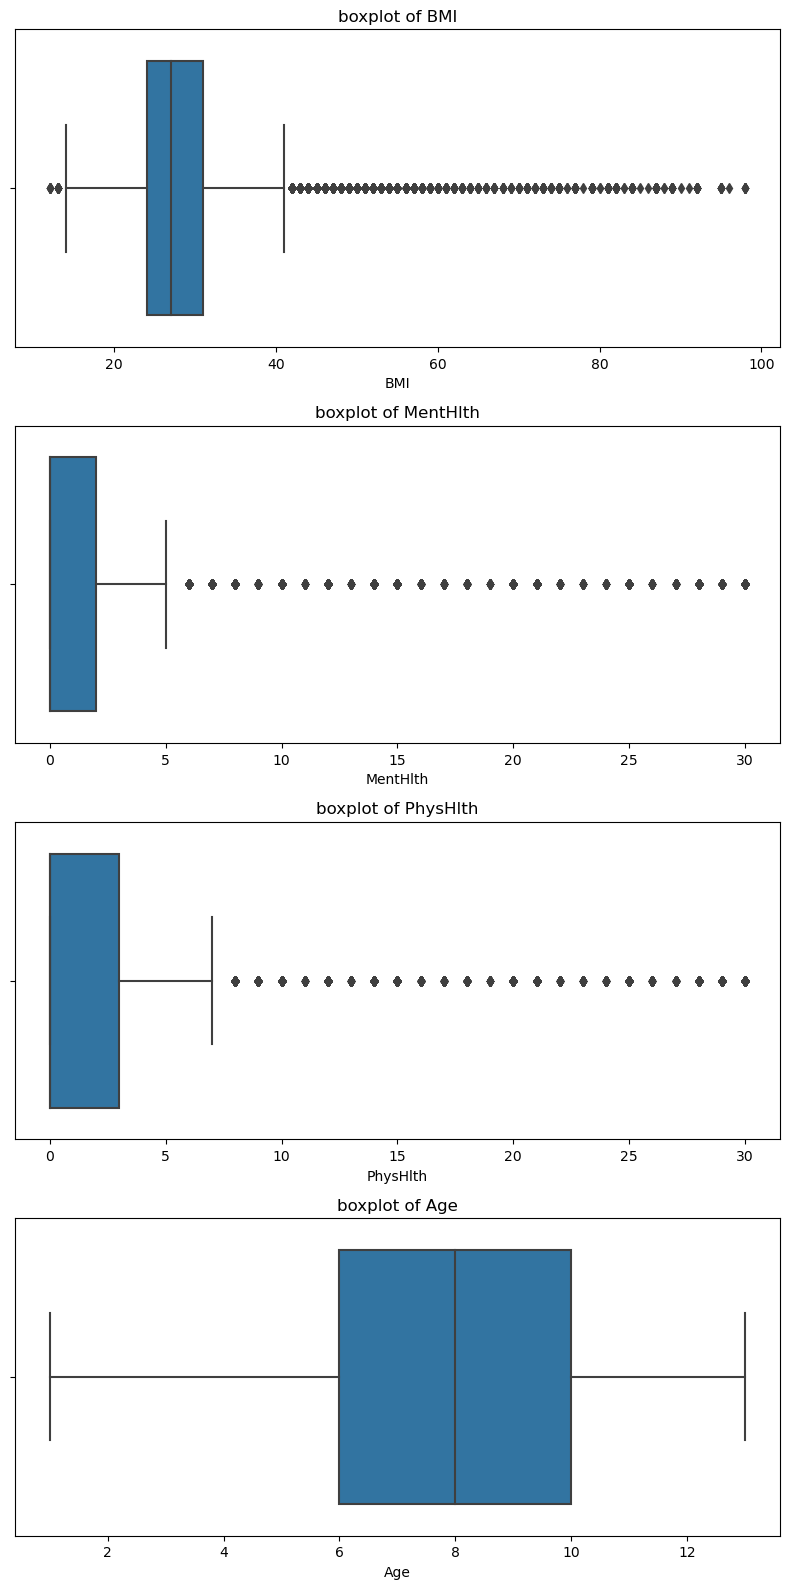

In [6]:
# boxplots
rutils.create_column_boxplot(df, separate_panels=True)

### Observations
* The outliers are a bit suspicious, because:
  * it is almost impossible to have a BMI > 40
  * people who report mental problems for the last 30 days might not have filled in the questionnaire reliably
  * possibly the same for physical health?

## Inspecting the data columns: correlation matrix

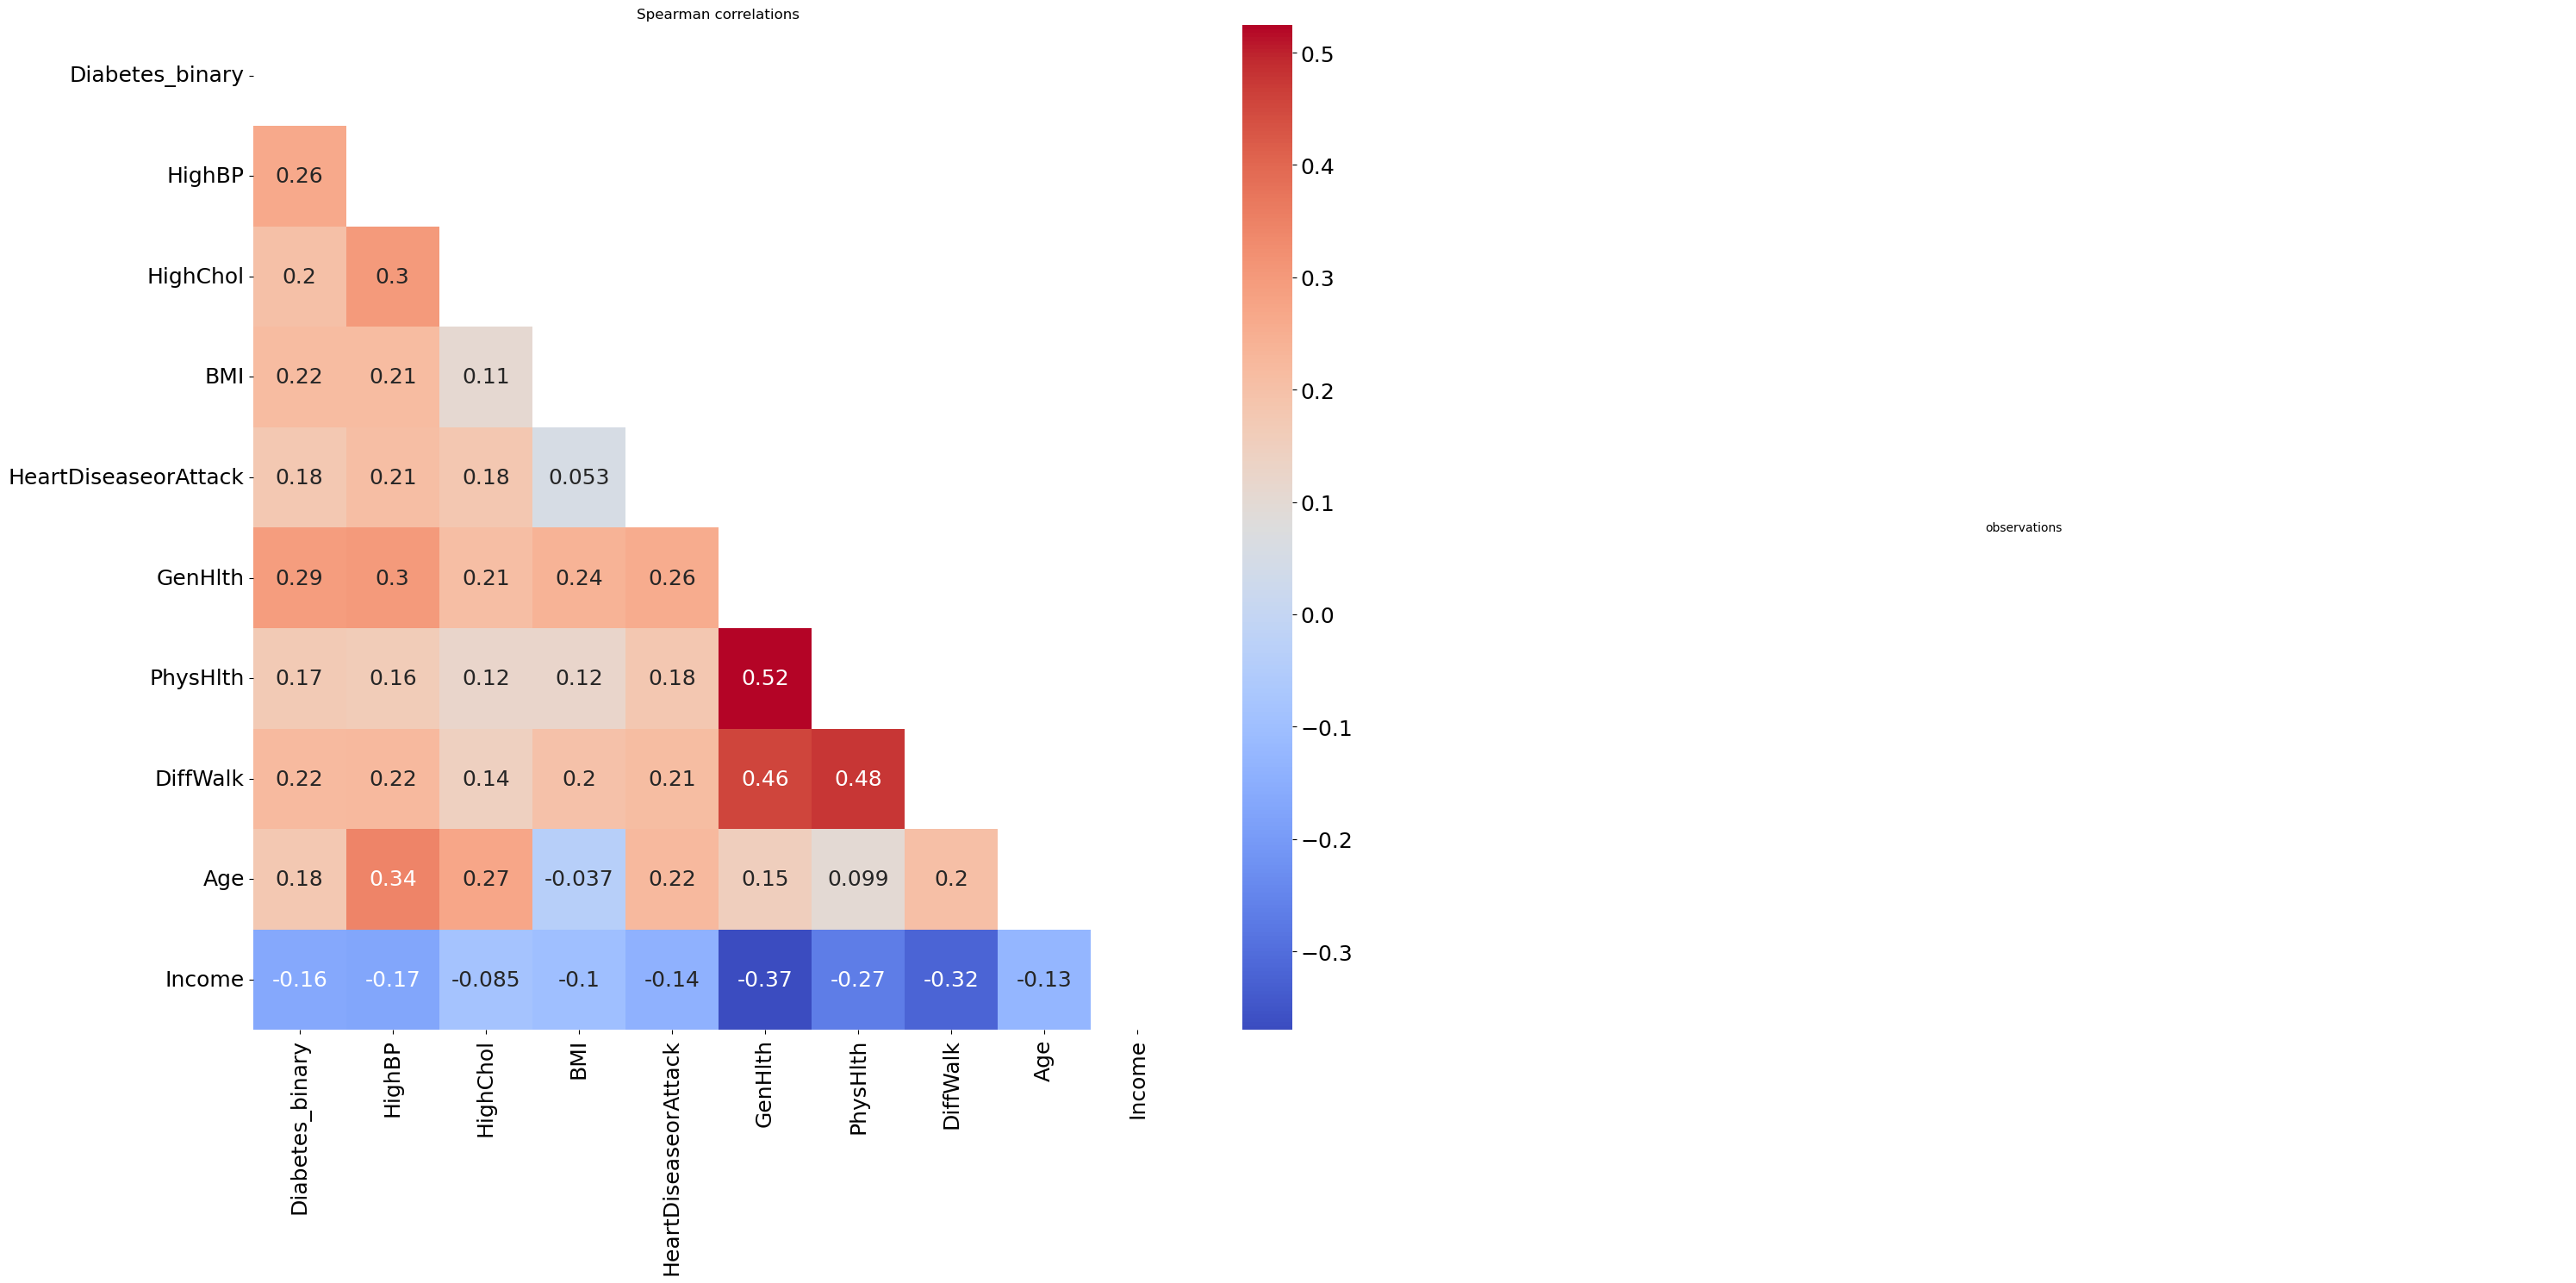

In [7]:
# correlation matrix
rutils.create_corr_plot(df, target_col = 'Diabetes_binary', threshold = 0.15)

## Research question(s)
One obvious type of analysis on this dataset would be to try predict the Diabetes_binary variable from the other variables. 

This kind of analysis may serve multiple purposes, including:
1. help identify factors that cause diabetes
2. help building diagnostic models that can estimate for any indivdiual the risk that they have or will develop diabetes

We can perform this analysis by training a classifier, using *Diabetes_binary* as output variable and the other variables (or a subset of them) as predictors. 

Multiple supervised methods are available for this kind of classification, including
* logistic regression (this would require reducing the output variable to a binary one)
* support vector machines
* decision trees and random forests
* neural networks

While it is generally useful to test out multiple methods, in the current report we will limit ourselves to Logistic Regression.

## Data preprocessing

**Missing data**<br>
We already established that there are no missing data, so we do not need to worry about this aspect.

**Outliers**<br>
Based on the observations above, we will perform the following data filtering when it comes to outliers:
1. Remove individuals with unusually high *BMI*. Reason: very high value are a bit suspicious and could be measurement errors
2. Remove individuals who score very high on *MentHlth*. Reason: individuals with severe mental health problems may not give reliable responses on a questionnaire about their own health
We will parameterize the threshold for these filters, so that we can play around with different settings for the filtering

**Transformation**<br>
All features are already numerical and they live on similar scales (numbers between 0 and 30, with only BMI being an exception), so for now we will not perform any transformations. If problems pop up, we can always come back to this later.

In [8]:
BMI_threshold = 50         # exclude extremely obese individuals
MentHlth_threshold = 20    # exclude inidividuals with severe mental health problems

# apply filters
n_before = df.shape[0]
df = df[df['BMI'] <= BMI_threshold]
df = df[df['MentHlth'] <= MentHlth_threshold]
print(f"Number of rows after filtering out extreme individuals: {df.shape[0]} ({100*df.shape[0]/n_before:.1f}% of all data)")

Number of rows after filtering out extreme individuals: 237548 (93.6% of all data)


## Classification analysis using logistic regression

In [9]:
# define the target variable (y) and the predictor variables (X)
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# specify column transformer (to scale the continuous features - we don't touch the binary ones)
binary_cols = [col for col in X_train.columns if X_train[col].nunique() == 2]
continuous_cols = [col for col in X_train.columns if col not in binary_cols]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('passthrough', 'passthrough', binary_cols)
    ])

# transform the columns
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# define the model and parameter spaces
logistic_regression = LogisticRegression(solver = 'saga', random_state=20230606)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [.0001, .001, .01, .1, 1, 10]
}
param_space_bayes = {
    'penalty': Categorical(['l1', 'l2']),
    'C': Real(.0001, 10, prior='log-uniform')
}

# define the fitting methods
methods = {
    'gridsearch': GridSearchCV(logistic_regression, param_grid, cv=5),
    'Bayes': BayesSearchCV(logistic_regression, param_space_bayes, cv=5, n_iter=50, random_state=20230606)
}

# loop over methods
for method in methods.keys():
    print(f"----{method}----")
    print(f"Fitting the model...")
    # fit the model using cross validation and measure time
    start_time = time.time()
    search = methods[method]
    search.fit(X_train, y_train)
    end_time = time.time()
    exec_time = end_time - start_time

    best_params = search.best_params_
    best_score = search.best_score_

    # evaluate predictions on the test set
    y_pred = search.predict(X_test)

    # show info about model performance
    classification_rep = classification_report(y_test, y_pred)
    print(f"Execution time: {exec_time:.1f} sec")
    print(f"Best parameters: {best_params}")
    print(f"Best score: {best_score:.4f}")
    print(f"Classification report:\n", classification_rep)


----gridsearch----
Fitting the model...
Execution time: 81.2 sec
Best parameters: {'C': 0.001, 'penalty': 'l2'}
Best score: 0.8708
Classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.98      0.93     41106
         1.0       0.56      0.12      0.20      6404

    accuracy                           0.87     47510
   macro avg       0.72      0.55      0.56     47510
weighted avg       0.83      0.87      0.83     47510

----Bayes----
Fitting the model...
Execution time: 361.5 sec
Best parameters: OrderedDict([('C', 0.0007596665625760154), ('penalty', 'l2')])
Best score: 0.8710
Classification report:
               precision    recall  f1-score   support

         0.0       0.88      0.99      0.93     41106
         1.0       0.55      0.12      0.19      6404

    accuracy                           0.87     47510
   macro avg       0.71      0.55      0.56     47510
weighted avg       0.83      0.87      0.83     47510



## Appendix 1: classifier performance as a function of hyperparameter *C*

A potential problem with Grid Search is that it tests only a limited set of (hyper)parameter values. What if the optimal value falls in between two grid points?

An advantage of Bayesian Search is that it actively explores parameter space; it is not limited to a pre-specified set of parameter values. 

In the analsyis above, we found C=0.001 as the best hyperparameter value when using grid search, and C=0.0007 when using Bayesian Search. However, the performance advantage of Bayesian Search was negligible (0.8710 accuracy vs 0.8708).

This suggests that the classifier accuracy might not be very sensitive to the value of hyperparameter *C*, in which case the extra time used by doing Bayesian Search is not really worth it.

To test this, we will now plot the best possible classifier accuracy as a function of different values of *C*.

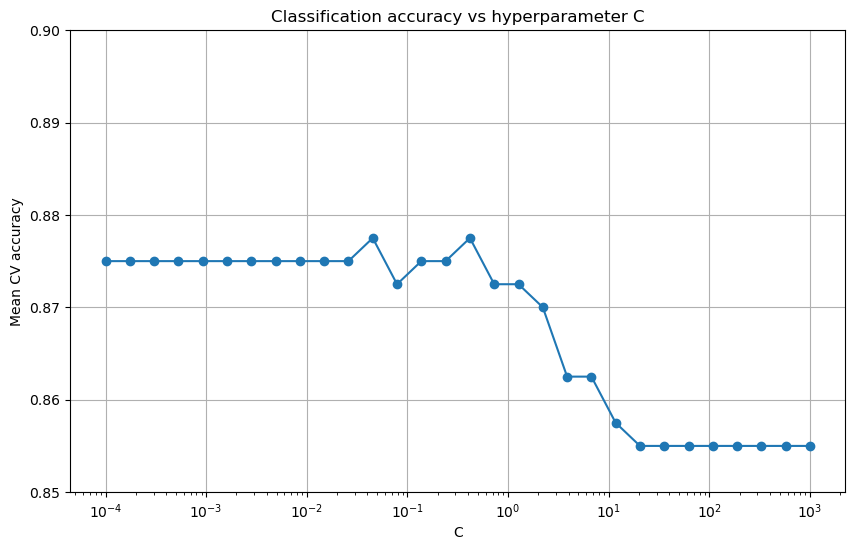

In [25]:
# define the values of C that we want to test (log spaced from .0001 to 1000)
C_vector = np.logspace(-4, 3, num=30)

# loop over C and store accuracy for each of them
accuracies = []
for C in C_vector:
    # fit the model using cross validation; use C as regularization parameter and 'l2' as penalty
    logistic_regression.C = C
    logistic_regression.penalty = 'l2'

    # use cross_val_score to get the accuracies for each split
    cv_scores = cross_val_score(logistic_regression, X_train, y_train, cv=5)

    # Store the mean accuracy for this value of C
    accuracies.append(np.mean(cv_scores))

# plot the result
plt.figure(figsize=(10, 6))
plt.semilogx(C_vector, accuracies, marker='o')
plt.xlabel('C')
plt.ylabel('Mean CV accuracy')
plt.title('Classification accuracy vs hyperparameter C')
plt.ylim((0.85, 0.90))
plt.grid(True)
plt.show()    

## Appendix 2: effect of C on classifier performance when using a smaller dataset

The result above showed that hyperparameter *C* barely affects the classifier accuracy in the problem at hand.

Perhaps it is so that *C* is only relevant when having relatively little data. 

To test this, we rerun the above analysis on just 500 rows (randomly sampled from the dataframe)

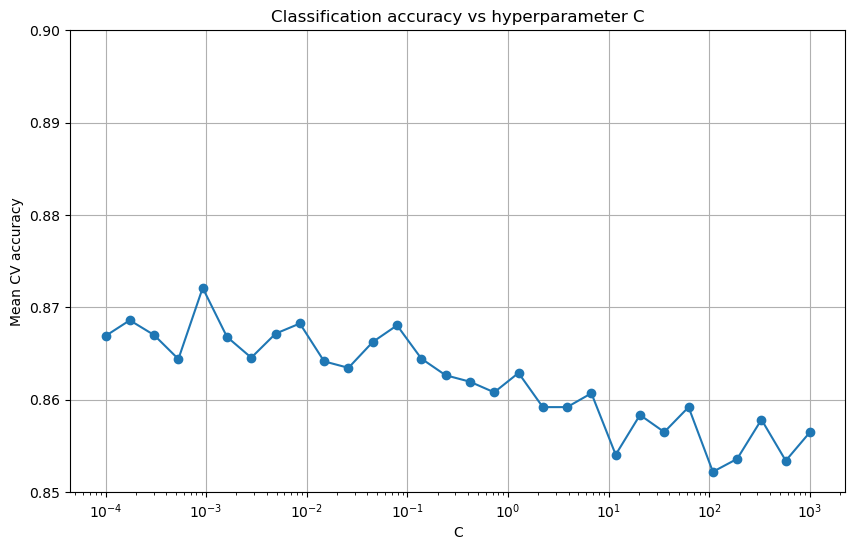

In [26]:
# define the model and parameter spaces
logistic_regression = LogisticRegression(solver = 'saga', random_state=20230606)

# define the values of C that we want to test (log spaced from .0001 to 10)
C_vector = np.logspace(-4, 3, num=30)

# number of runs
n_runs = 50

# Initialize an empty list to store mean accuracies for each C
mean_accuracies = []

# loop over C
for C in C_vector:
    # Initialize a list to store accuracies for each run
    accuracies = []
    
    # loop over runs
    for run in range(n_runs):
        df_sample = df.sample(n=500)

        # define the target variable (y) and the predictor variables (X)
        X = df_sample.drop('Diabetes_binary', axis=1)
        y = df_sample['Diabetes_binary']

        # split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # specify column transformer (to scale the continuous features - we don't touch the binary ones)
        binary_cols = [col for col in X_train.columns if X_train[col].nunique() == 2]
        continuous_cols = [col for col in X_train.columns if col not in binary_cols]
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), continuous_cols),
                ('passthrough', 'passthrough', binary_cols)
            ])

        # transform the columns
        X_train = preprocessor.fit_transform(X_train)
        X_test = preprocessor.transform(X_test)

        # fit the model using cross validation; use C as regularization parameter and 'l2' as penalty
        logistic_regression.C = C
        logistic_regression.penalty = 'l2'

        # use cross_val_score to get the accuracies for each split
        cv_scores = cross_val_score(logistic_regression, X_train, y_train, cv=5)

        # store the mean accuracy for this run
        accuracies.append(np.mean(cv_scores))
    
    # calculate the mean accuracy across all runs for the current C value
    mean_accuracies.append(np.mean(accuracies))

# plot the result
plt.figure(figsize=(10, 6))
plt.semilogx(C_vector, mean_accuracies, marker='o')
plt.xlabel('C')
plt.ylabel('Mean CV accuracy')
plt.title('Classification accuracy vs hyperparameter C')
plt.grid(True)
plt.ylim((0.85, 0.90))
plt.show()

## Summary

* Whether someone has diabetes can be predicted quite well from variables related to a person's general health and lifestyle (87% accuracy)
* This was just a preliminary analysis - we might get even better performance by trying out other types of models
* In the present case, performance of the logistic regression classifier was not strongly affected by hyperparameter *C*: as long as the value is in the right ballpark, classifier performance will be close to optimal
    * this justifies using a simple Grid Search instead of more precise but also more expensive methods such as Bayesian Search